In [1]:
import numpy as np, pandas as pd, h5py
import matplotlib.pyplot as plt
import glob
from scipy.ndimage import gaussian_filter1d
import fitsio
import skyproj
import healpy as hp

import os
if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2021-el7-x86_64/bin/x86_64-linux"
    
    
COLORS = ["219ebc", "c767ac", "59a270", "ffba0a", "f07167",]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ] + ["gray"]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

In [2]:
plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=13)

# Load all samples

In [3]:
NSIDE = 1024
with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20240209.hdf', 'r') as f:
    
    mask = f['baseline_mcal_mask_noshear'][:] > 0
    hpix = hp.ang2pix(NSIDE, f['RA'][:][mask], f['DEC'][:][mask], lonlat = True)
    ngal = np.bincount(hpix, minlength = hp.nside2npix(NSIDE)) / (hp.nside2pixarea(NSIDE, degrees = True) * 60**2)

In [4]:
boss_cat = fitsio.read('/project/chihway/data/decade/BOSS_eBOSS.fits') #get Z, RA, DEC from here

hpix = hp.ang2pix(NSIDE, boss_cat['RA'], boss_cat['DEC'], lonlat = True)
mask = (ngal > 0)[hpix]
boss_cat = boss_cat[mask]

hpix = hp.ang2pix(256, boss_cat['RA'], boss_cat['DEC'], lonlat = True)
ngal_boss = np.bincount(hpix, minlength = hp.nside2npix(256)) / (hp.nside2pixarea(256, degrees = True) * 60**2)

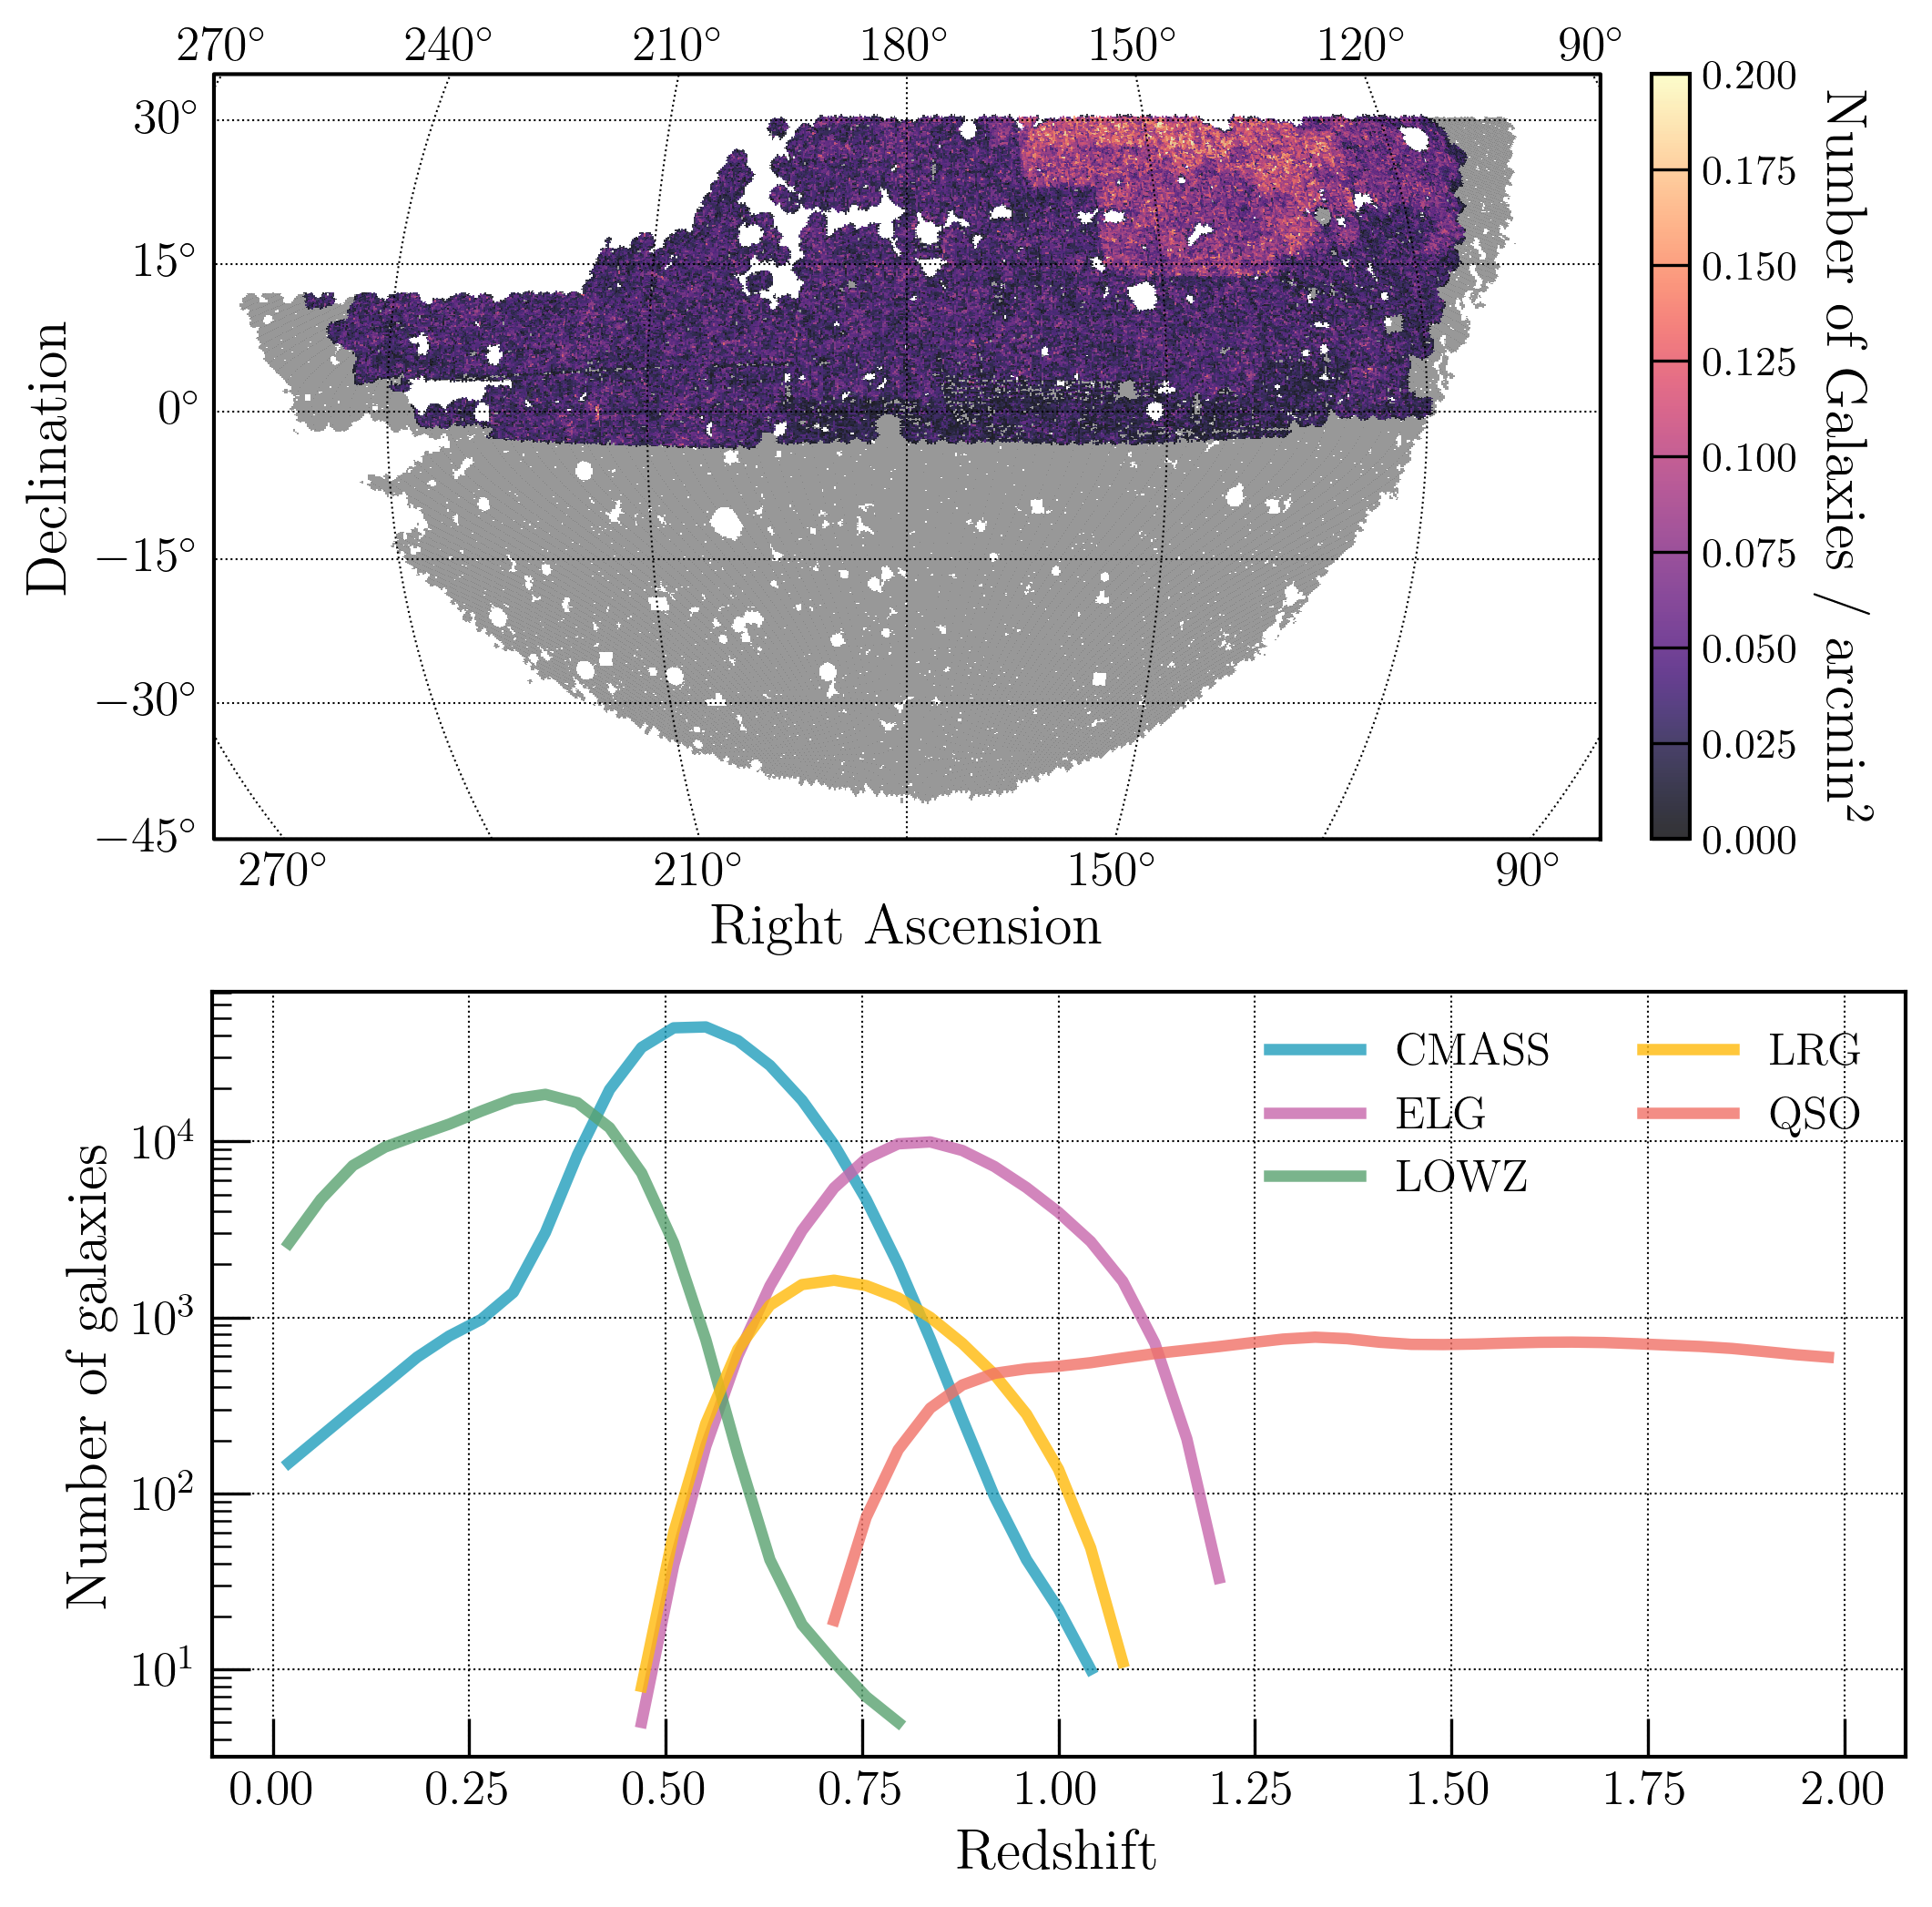

In [5]:
fig, ax = plt.subplots(2, figsize=(8, 8), dpi=300)

sp = skyproj.McBrydeSkyproj(lon_0=180, ax=ax[0], extent = [100, 260, -45, 35])

# Note that the default is to zoom in to the range defined by the map
sp.draw_hpxmap(np.where(ngal > 0, 1, hp.UNSEEN), zoom=False, label='DELVE', cmap = 'gray', alpha = 0.8)
sp.draw_hpxmap(np.where(ngal_boss > 0, ngal_boss, hp.UNSEEN), zoom=False, vmin=0, vmax=0.2, cmap='magma', label='BOSS, eBOSS', alpha = 0.8)
sp.ax.set_xlabel("Right Ascension", fontsize=15)
sp.ax.set_ylabel("Declination", fontsize=15)

cbar = sp.draw_colorbar(pad = 0.03)
cbar.set_label(r"Number of Galaxies / arcmin$^2$", rotation=270, labelpad=20, fontsize = 15)


samples = list(np.unique(boss_cat['SAMPLE']))
bins    = np.linspace(0, 2, 50)
for s in samples:
    m = np.ones(len(boss_cat), dtype = bool) if s == 'ALL' else boss_cat['SAMPLE'] == s 
    c, b = np.histogram(boss_cat['Z'][m], bins = bins)
    c    = gaussian_filter1d(c, 0.05/(b[1] - b[0]))
    b = (b[1:] + b[:-1])/2
    
    m = c > 3
    ax[1].plot(b[m], c[m], label = s, lw = 3, alpha = 0.8)
    
ax[1].set_yscale('log')
ax[1].legend(fontsize = 12, ncol = 2)
ax[1].grid(linestyle = ':', color = 'k', linewidth = 0.5)

ax[1].set_xlabel("Redshift", fontsize=15)
ax[1].set_ylabel(r"Number of galaxies", fontsize=15)

plt.savefig('./reference_sample.pdf', dpi = 300, bbox_inches = 'tight')